In [8]:
import os

os.environ["TAVILY_API_KEY"] = "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"

In [9]:

from langchain.chat_models import init_chat_model
llm = init_chat_model("ollama:llama3.2")

In [10]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

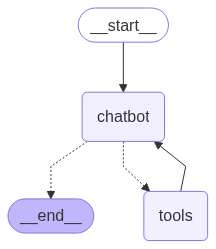

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (2ea99a3d-dce2-4fb3-8750-94e76d443fe4)
 Call ID: 2ea99a3d-dce2-4fb3-8750-94e76d443fe4
  Args:
    query: What is the most recent news on climate change?
    start_date: 2024-01-15
    time_range: month
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 400: When time_range is set, start_date or end_date cannot be set')}
================================== Ai Message ==================================

It seems like you requested information for a specific date range, but didn't provide an end date. Climate news can vary widely from month to month, let me try again.

Can I search for recent news on climate change instead?


In [14]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (59982b23-dea1-4085-bd56-be626b06f5ea)
 Call ID: 59982b23-dea1-4085-bd56-be626b06f5ea
  Args:
    end_date: None
    query: climate change news
    start_date: None
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "climate change news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnn.com/climate", "title": "Climate change", "content": "Follow CNN's news coverage of climate change, global warming, greenhouse gases, carbon emissions and environmental impact to sea level, extreme weather and", "score": 0.67758125, "raw_content": null}, {"url": "https://insideclimatenews.org/", "title": "Inside Climate News: Home", "content": "## World’

In [15]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (d2b64aec-5c50-4798-99b9-e2e7902d0622)
 Call ID: d2b64aec-5c50-4798-99b9-e2e7902d0622
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_favicon: False
    include_images: True
    query: climate change policy
    search_depth: advanced
    start_date: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "climate change policy", "follow_up_questions": null, "answer": null, "images": ["http://cdn.statcdn.com/Infographic/images/normal/24038.jpeg", "https://ichef.bbci.co.uk/news/2048/cpsprodpb/16CBE/production/_131947339_2023-12-05-climate_warming-cat-projections_dec2023-nc.png", "https://cdn.britannica.com/92/192592-004-1B419DE3/Timeline-developments-climate-cha

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='c91b5ebc-bfb2-49b2-a87c-19c66e9ceb07'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-09-12T04:26:38.0548814Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5787484500, 'load_duration': 2198621300, 'prompt_eval_count': 1525, 'prompt_eval_duration': 2062389900, 'eval_count': 46, 'eval_duration': 1524874700, 'model_name': 'llama3.2'}, id='run--c1211323-4943-4671-a48d-d49429efa3c1-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'What is the most recent news on climate change?', 'start_date': '2024-01-15', 'time_range': 'month'}, 'id': '2ea99a3d-dce2-4fb3-8750-94e76d443fe4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1525, 'output_tokens': 46, 'total_tokens': 1571}), ToolMessage(content="{'error': ValueError('Error 400: When time_range is set, start_date or end_date c

In [17]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()